In [1]:
pip install opencv-python pillow numpy scikit-learn tensorflow torch torchvision


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/d3/1d/a257913c89572de61316461db91867f87519146e58132cdeace3d9ffbe1f/torch-2.3.1-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.3.1-cp311-cp311-win_amd64.whl.metadata (26 kB)
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e4/c3/a21a75dd2de8114a6876f16a36b033e3e62f8ade68085a711b24f4b57c17/torchvision-0.18.1-cp311-cp311-win_amd64.whl.metadata
  Using cached torchvision-0.18.1-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
  Obtaining dependency information for typing-extensions>=3.6.6 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Obtaining dependency information for mkl<=2021.4.0,>=2021.1.1 from https://files.pythonhosted.org/packages/fe/1c/5f6dbf18e8b73e

ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [12]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr


In [13]:
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, img_size)  # Resize image
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return images


In [51]:
noisy_folder_path = 'D:\Train\Train\low' # change path accordingly 
clean_folder_path = 'D:\Train\Train\high' # change path accordingly
img_size = (128, 128)  # Desired image size

noisy_images = load_images_from_folder(noisy_folder_path, img_size)
clean_images = load_images_from_folder(clean_folder_path, img_size)


In [15]:
train_noisy, train_noisy, train_clean, train_clean = train_test_split(
    noisy_images, clean_images, test_size=0.2, random_state=42
)


In [16]:
def preprocess_image(image):
    return tf.image.convert_image_dtype(image, tf.float32)

# Create TensorFlow datasets
train_noisy_ds = tf.data.Dataset.from_tensor_slices(train_noisy).map(preprocess_image).batch(32)
train_clean_ds = tf.data.Dataset.from_tensor_slices(train_clean).map(preprocess_image).batch(32)
test_noisy_ds = tf.data.Dataset.from_tensor_slices(test_noisy).map(preprocess_image).batch(32)
test_clean_ds = tf.data.Dataset.from_tensor_slices(test_clean).map(preprocess_image).batch(32)

# Combine noisy and clean images for training
train_ds = tf.data.Dataset.zip((train_noisy_ds, train_clean_ds))
test_ds = tf.data.Dataset.zip((test_noisy_ds, test_clean_ds))


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Sequential
from tensorflow.keras.layers import LeakyReLU

# Define the PSNR function
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

# Define the custom PSNR callback
class PSNRCallback(callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_data = self.validation_data
        val_pred = self.model.predict(val_data[0])
        logs['val_psnr'] = psnr(val_data[1], val_pred).numpy().mean()
        print(f"Epoch {epoch + 1}: val_psnr = {logs['val_psnr']}")

# Define the denoising model
def create_denoising_model(input_shape):
    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model

# Example usage
input_shape = (128, 128, 3)  
model = create_denoising_model(input_shape)
# Compile with Adam optimizer and monitor PSNR during training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[psnr])
model.summary()

# Assuming you have training and validation datasets: train_ds and test_ds
val_data = next(iter(test_ds))  # Extract a batch from the validation dataset

# Instantiate the custom PSNR callback with validation data
psnr_callback = PSNRCallback(validation_data=val_data)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,731 (194.26 KB)

 Trainable params: 49,731 (194.26 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Assuming you have training and validation datasets: train_ds and test_ds
history = model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[psnr_callback])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/stepep - loss: 0.6891 - psnr: 13.78
Epoch 1: val_psnr = 15.602646827697754
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 947ms/step - loss: 0.6888 - psnr: 13.8024 - val_loss: 0.6679 - val_psnr: 15.6026
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/stepep - loss: 0.6679 - psnr: 15.35
Epoch 2: val_psnr = 15.428247451782227
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 749ms/step - loss: 0.6677 - psnr: 15.3571 - val_loss: 0.6573 - val_psnr: 15.4282
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/stepep - loss: 0.6608 - psnr: 15.57
Epoch 3: val_psnr = 15.796956062316895
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 774ms/step - loss: 0.6605 - psnr: 15.5818 - val_loss: 0.6515 - val_psnr: 15.7970
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/stepep - loss: 0.6544 - psnr: 15.95
Epoch 4: val_psnr = 15.990021705627441
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 745ms/step - loss: 0.6541 - psnr: 15.9670 - val_loss: 0.6553 - val_psnr: 15.9900
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/stepep - loss: 0.6570 

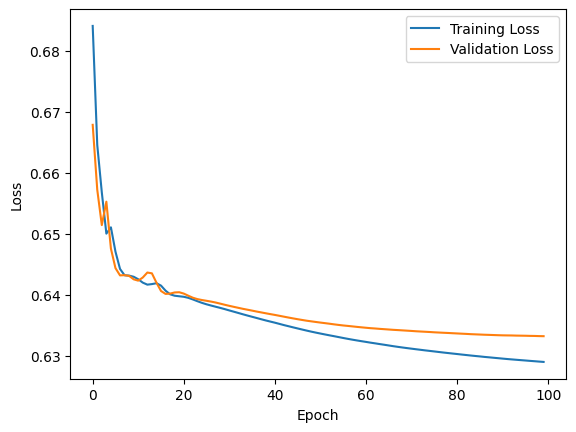

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
predicted_images = model.predict(test_noisy_ds)

psnr_values = [psnr(test_clean[i], predicted_images[i]) for i in range(len(test_clean))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Average PSNR: 17.737285614013672


In [62]:
predicted_images = model.predict(train_noisy_ds)

psnr_values = [psnr(train_clean[i], predicted_images[i]) for i in range(len(train_clean))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Average PSNR: 18.038999557495117


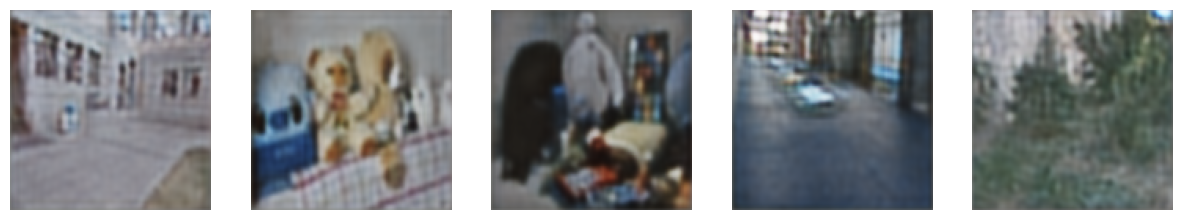

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images from the given array
def display_images(images, num_images_to_display=5):
    # Determine how many images to display
    num_images = min(num_images_to_display, images.shape[0])
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    for i in range(num_images):
        ax = axes[i] if num_images > 1 else axes
        ax.imshow(images[i])
        ax.axis('off')
    
    plt.show()

# Assuming predicted_images is already defined and is a 4D NumPy array
# Example: predicted_images = np.random.rand(10, 64, 64, 3) # Just for demonstration

display_images(predicted_images)

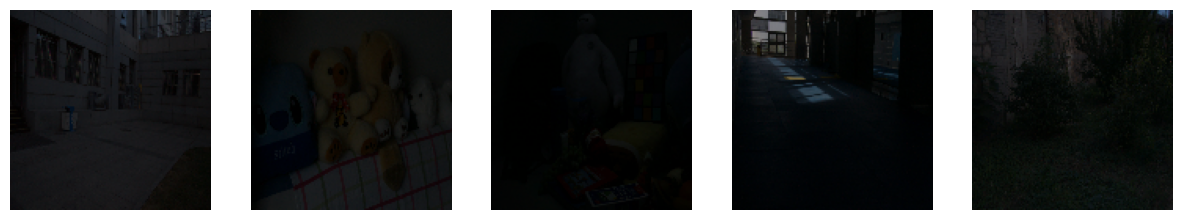

In [58]:
noisy_images = np.array(test_noisy)
display_images(noisy_images)

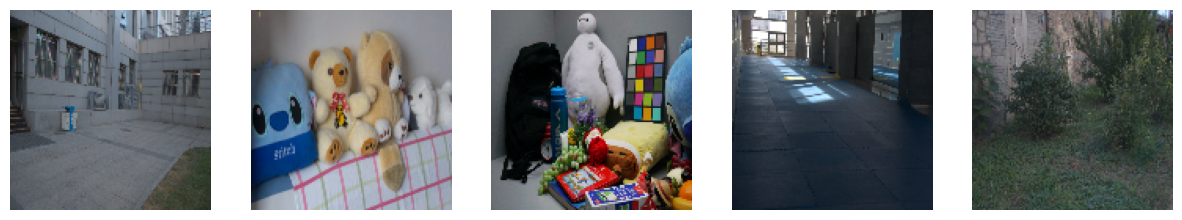

In [59]:
clean_images = np.array(test_clean)
display_images(clean_images)